## 네트워크 훈련 및 저장

In [1]:
import tensorflow as tf
import numpy as np
import hdf5storage

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [2]:
training_set = hdf5storage.loadmat('./CNN_training.mat')
XTrain, YTrain = training_set['XTrain'], training_set['YTrain']
XTrain = np.transpose(XTrain, [3,0,1,2])
print(XTrain.shape)
print(YTrain.shape)

(3100, 64, 32, 1)
(3100, 2)


### parameter 설정

In [3]:
learning_rate = 0.01
total_epoch = 15
batch_size = 100
total_batch = int(len(XTrain) / batch_size)

In [4]:
X = tf.placeholder(tf.float32, [None,64, 32,1], name='input') #64x32 크기의 회색조(1)
Y = tf.placeholder(tf.float32, [None, 2], name='label') # 0 또는 1을 담을 크기1 (Busy / Idle)
keep_prob = tf.placeholder(tf.float32, name='drop')

W1 = tf.Variable(tf.random_normal([3,3, 1, 16], stddev=0.01), name='weight1') 
L1 = tf.nn.conv2d(X, W1, strides=[1, 1, 1, 1], padding = 'SAME')
L1 = tf.nn.relu(L1)
L1 = tf.nn.max_pool(L1, ksize = [1, 2, 2, 1], strides=[1, 2, 2, 1],padding = 'SAME') 

W2 = tf.Variable(tf.random_normal([3, 3, 16, 32], stddev=0.01), name='weight2')  
L2 = tf.nn.conv2d(L1, W2, strides=[1, 1, 1, 1], padding='SAME')
L2 = tf.nn.relu(L2)
L2 = tf.nn.max_pool(L2, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1],padding='SAME')

W3 = tf.Variable(tf.random_normal([3, 3, 32, 64], stddev=0.01), name='weight3')
L3 = tf.nn.conv2d(L2, W3, strides=[1, 1, 1, 1], padding='SAME')
L3 = tf.nn.relu(L3)
L3 = tf.nn.max_pool(L3, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1],padding='SAME')

W4 = tf.Variable(tf.random_normal([8 * 4 * 64, 256], stddev=0.01), name='weight4')
L4 = tf.reshape(L3, [-1, 8 * 4 * 64])
L4 = tf.matmul(L4, W4)
L4 = tf.nn.relu(L4)
L4 = tf.nn.dropout(L4, keep_prob)

W5 = tf.Variable(tf.random_normal([256, 2], stddev=0.01), name='weight5')
model = tf.matmul(L4, W5)
model = tf.identity(model, name='model')

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = model, labels = Y))
#optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [5]:
saver = tf.train.Saver() # saver

sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())

for epoch in range(total_epoch):
    total_cost = 0
    
    for i in range(total_batch):
        batch_xs = XTrain[batch_size*i:batch_size*(i+1),:,:,:]
        batch_ys = YTrain[batch_size*i:batch_size*(i+1),:]

        _, cost_val = sess.run([optimizer, cost], 
                               feed_dict = {X: batch_xs, Y: batch_ys, 
                                            keep_prob:0.8})
        total_cost += cost_val
    print('Epoch :', '%4d' %(epoch + 1),
          'Avg. cost = ', '{:.3f}'.format(total_cost / total_batch))
    
print("최적화 완료!")
saver.save(sess, './network/Net_3100_epoch15/net') # netwrok save

Epoch :    1 Avg. cost =  0.499
Epoch :    2 Avg. cost =  0.435
Epoch :    3 Avg. cost =  0.418
Epoch :    4 Avg. cost =  0.405
Epoch :    5 Avg. cost =  0.359
Epoch :    6 Avg. cost =  0.299
Epoch :    7 Avg. cost =  0.277
Epoch :    8 Avg. cost =  0.244
Epoch :    9 Avg. cost =  0.227
Epoch :   10 Avg. cost =  0.207
Epoch :   11 Avg. cost =  0.202
Epoch :   12 Avg. cost =  0.203
Epoch :   13 Avg. cost =  0.184
Epoch :   14 Avg. cost =  0.172
Epoch :   15 Avg. cost =  0.205
최적화 완료!


'./network/Net_3100_epoch15/net'

## 테스트 & 모델 불러오기

In [1]:
import tensorflow as tf
import numpy as np
import hdf5storage
import matplotlib.pyplot as plt

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

#tf.reset_default_graph()

In [2]:
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())

saver = tf.train.import_meta_graph('./network/Net_3100_epoch15/net.meta')
saver.restore(sess, './network/Net_3100_epoch15/net')

X = sess.graph.get_tensor_by_name('input:0')
Y = sess.graph.get_tensor_by_name('label:0')
keep_prob = sess.graph.get_tensor_by_name('drop:0')

W1 = sess.graph.get_tensor_by_name('weight1:0')
L1 = tf.nn.conv2d(X, W1, strides=[1, 1, 1, 1], padding = 'SAME')
L1 = tf.nn.relu(L1)
L1 = tf.nn.max_pool(L1, ksize = [1, 2, 2, 1], strides=[1, 2, 2, 1],padding = 'SAME') 

W2 = sess.graph.get_tensor_by_name('weight2:0')
L2 = tf.nn.conv2d(L1, W2, strides=[1, 1, 1, 1], padding='SAME')
L2 = tf.nn.relu(L2)
L2 = tf.nn.max_pool(L2, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1],padding='SAME')

W3 = sess.graph.get_tensor_by_name('weight3:0')
L3 = tf.nn.conv2d(L2, W3, strides=[1, 1, 1, 1], padding='SAME')
L3 = tf.nn.relu(L3)
L3 = tf.nn.max_pool(L3, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1],padding='SAME')

W4 = sess.graph.get_tensor_by_name('weight4:0')
L4 = tf.reshape(L3, [-1, 8 * 4 * 64])
L4 = tf.matmul(L4, W4)
L4 = tf.nn.relu(L4)
L4 = tf.nn.dropout(L4, keep_prob)

W5 = sess.graph.get_tensor_by_name('weight5:0')

model = sess.graph.get_tensor_by_name('model:0')

is_correct = tf.equal(tf.argmax(model, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))

INFO:tensorflow:Restoring parameters from ./network/Net_3100_epoch15/net


In [3]:
test_set = hdf5storage.loadmat('./CNN_test_500_time64.mat')
XTest, YTest = test_set['XTest'], test_set['YTest']
XTest = np.transpose(XTest, [3,0,1,2,4])
print(XTest.shape)
print(YTest.shape)

(15500, 64, 32, 1, 14)
(15500, 28)


In [4]:
YTest_SNR = np.zeros([len(YTest),2],dtype='f')

SNR_table = list(range(-20, 7, 2))
fdr_list,mdr_list,acc_list=[],[],[]

for SNR_loop in range(len(SNR_table)):
    XTest_SNR = XTest[:,:,:,:,SNR_loop]
    YTest_SNR[:,1] = YTest[:,SNR_loop]
    YTest_SNR[:,0] = YTest[:,SNR_loop+14]
    Pred, acc = sess.run([model, accuracy], 
                         feed_dict={ X: XTest_SNR, Y: YTest_SNR, keep_prob: 1.0})
    
    fdr,mdr = 0,0
    busy_cnt,idle_cnt = 0,0
    
    for n in range(len(Pred)):
        if (np.argmax(YTest_SNR,1)[n] == 1):
            if np.argmax(Pred,1)[n] != np.argmax(YTest_SNR,1)[n]:
                fdr=fdr+1
            busy_cnt=busy_cnt+1
        else:
            if np.argmax(Pred,1)[n] != np.argmax(YTest_SNR,1)[n]:
                mdr=mdr+1
            idle_cnt=idle_cnt+1
    fdr_list.append(fdr/busy_cnt)
    mdr_list.append(mdr/idle_cnt)
    acc_list.append(acc)
    
    print('SNR:', '%d dB' % SNR_table[SNR_loop],' 정확도: %4f' % acc)

SNR: -20 dB  정확도: 0.511032
SNR: -18 dB  정확도: 0.510839
SNR: -16 dB  정확도: 0.532645
SNR: -14 dB  정확도: 0.541548
SNR: -12 dB  정확도: 0.576839
SNR: -10 dB  정확도: 0.664194
SNR: -8 dB  정확도: 0.765419
SNR: -6 dB  정확도: 0.900065
SNR: -4 dB  정확도: 0.961871
SNR: -2 dB  정확도: 0.963032
SNR: 0 dB  정확도: 0.967806
SNR: 2 dB  정확도: 0.961097
SNR: 4 dB  정확도: 0.963871
SNR: 6 dB  정확도: 0.971161


# Plot

### FDR: False detection ratio
### MDR: Miss detection ratio
### ACC

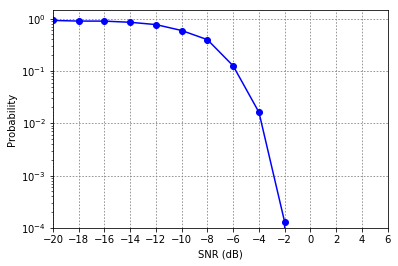

In [20]:
plt.semilogy(SNR_table, fdr_list, '-bo')
plt.xticks(SNR_table) 
plt.xlim(-20, 6)
plt.ylim(0.0001, 0)
plt.xlabel('SNR (dB)')
plt.ylabel('Probability')
plt.grid(color='gray',dashes=(2,2))
plt.show()

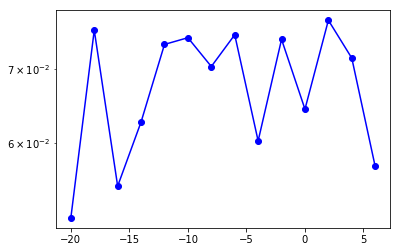

In [21]:
plt.semilogy(SNR_table, mdr_list, '-bo')

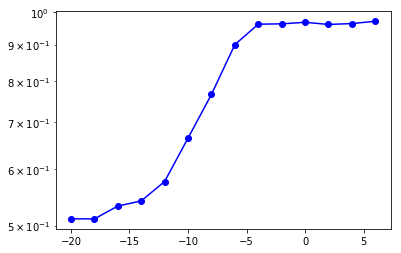

In [22]:
plt.semilogy(SNR_table, acc_list, '-bo')